In [1]:
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

#ScoreCAM

In [2]:
!git clone https://github.com/yiskw713/ScoreCAM.git

Cloning into 'ScoreCAM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 2), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), 3.29 MiB | 11.96 MiB/s, done.


In [3]:
import sys
sys.path.append('/content/ScoreCAM')

In [4]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F
from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


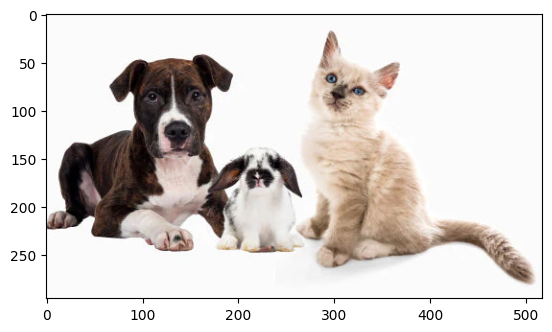

In [6]:
image = Image.open('/content/drive/MyDrive/AI_Lab/dog_cat.jpg')
imshow(image)

In [7]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [8]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [9]:
tensor.shape

torch.Size([1, 3, 296, 517])

In [10]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# the target layer you want to visualize
target_layer = model.layer4[1].conv2

wrapper for class activation mapping. Choose one of the following.

In [12]:
# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
# wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)
wrapped_model = ScoreCAM(model, target_layer)

In [13]:
cam, idx = wrapped_model(tensor)

In [14]:
print(idx2label[idx])

Siamese cat, Siamese


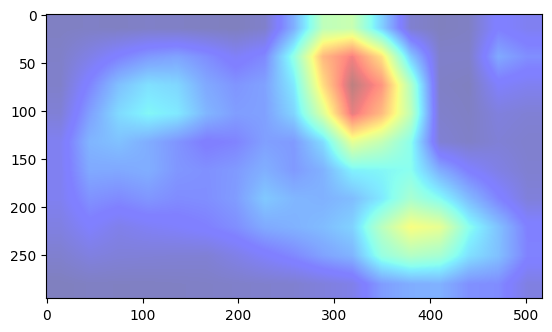

In [15]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [16]:

# reverse normalization for display
img = reverse_normalize(tensor)

In [17]:
heatmap = visualize(img, cam)

In [18]:
# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

In [ ]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.int32)
imshow(hm)

Function to add noise where mask value is 1

In [19]:

def perturb_image(image, saliency_map, perturbation_strength=0.01, saliency_threshold=0.5):
    # Get the top n percent of saliency values
    saliency_values = saliency_map.view(-1)
    threshold = torch.kthvalue(saliency_values, int((1 - saliency_threshold) * saliency_values.size(0)) + 1).values
    
    # Threshold the saliency map and generate a mask
    mask = torch.gt(saliency_map, threshold).float()
    
    # Add random noise to the image where the mask is 1
    noise = torch.randn_like(image) * perturbation_strength
    perturbed_image = image + mask * noise
    # print(perturbed_image.shape)
    
    # Clip the pixel values to [0,1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image


In [20]:
perturbed_tensor = perturb_image(tensor, cam, cam > 0.5, 0.1)

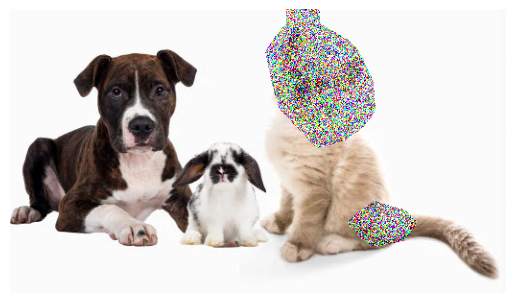

In [21]:
import matplotlib.pyplot as plt
# Convert the tensor to a numpy array
image_array = perturbed_tensor.squeeze().permute(1,2,0).detach().cpu().numpy()

# Normalize the array to [0, 1]
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Show the image using matplotlib
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [22]:
perturbed_cam, perturbed_idx = wrapped_model(perturbed_tensor)

In [23]:
print(idx2label[perturbed_idx])

Weimaraner


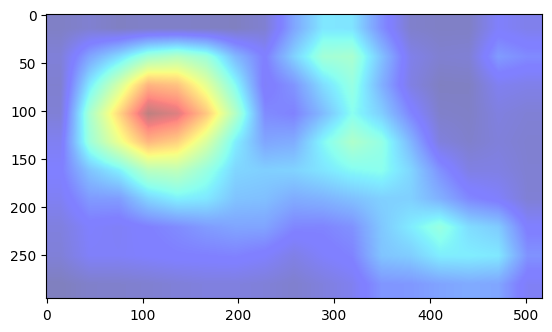

In [24]:
imshow(perturbed_cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [25]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [ ]:
heatmap = visualize(img, perturbed_cam)

In [26]:
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[perturbed_idx]).replace(" ", "_").replace(",", ""))

#Test Cases

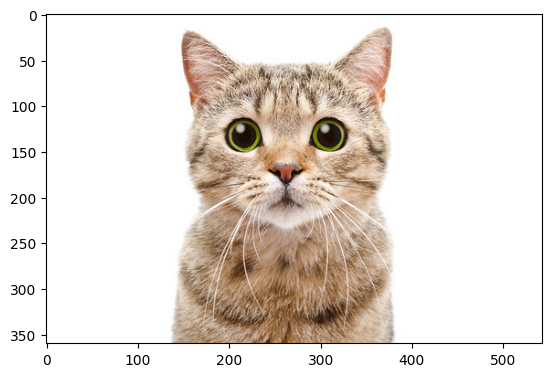

In [27]:
image = Image.open('/content/drive/MyDrive/AI_Lab/cat.jpg')
imshow(image)

In [28]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [29]:
cam, idx = wrapped_model(tensor)

In [30]:
print(idx2label[idx])

tabby, tabby cat


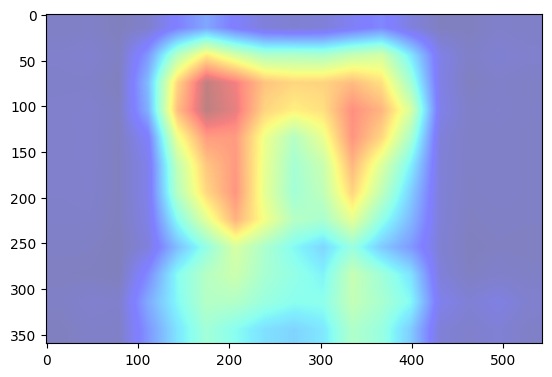

In [31]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [32]:

# reverse normalization for display
img = reverse_normalize(tensor)

In [33]:
heatmap = visualize(img, cam)
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

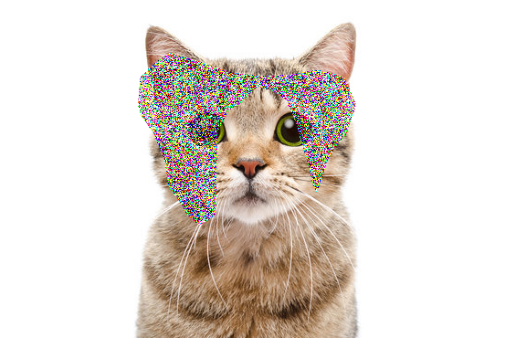

In [34]:
perturbed_tensor = perturb_image(tensor, cam, cam > 0.5, 0.1)
# Convert the tensor to a numpy array
image_array = perturbed_tensor.squeeze().permute(1,2,0).detach().cpu().numpy()

# Normalize the array to [0, 1]
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Show the image using matplotlib
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [35]:
perturbed_cam, perturbed_idx = wrapped_model(perturbed_tensor)
print(idx2label[perturbed_idx])

Egyptian cat


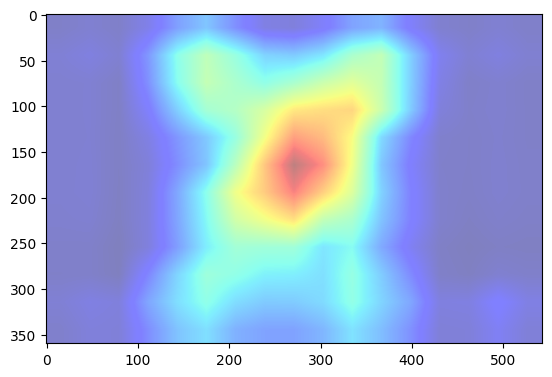

In [36]:
imshow(perturbed_cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [37]:
# reverse normalization for display
img = reverse_normalize(tensor)
heatmap = visualize(img, perturbed_cam)
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[perturbed_idx]).replace(" ", "_").replace(",", ""))

2nd Test case

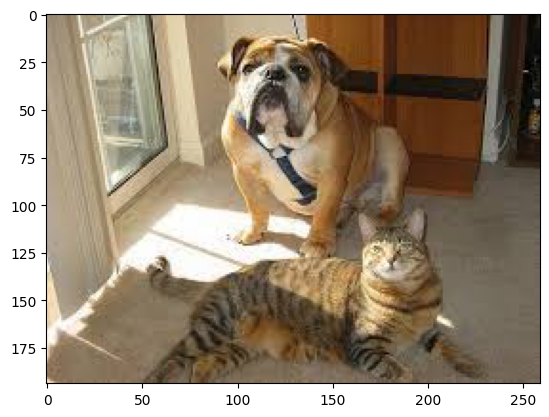

In [38]:
image = Image.open('/content/drive/MyDrive/AI_Lab/classic.jpeg')
imshow(image)

In [39]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [40]:
cam, idx = wrapped_model(tensor)
print(idx2label[idx])

tiger cat


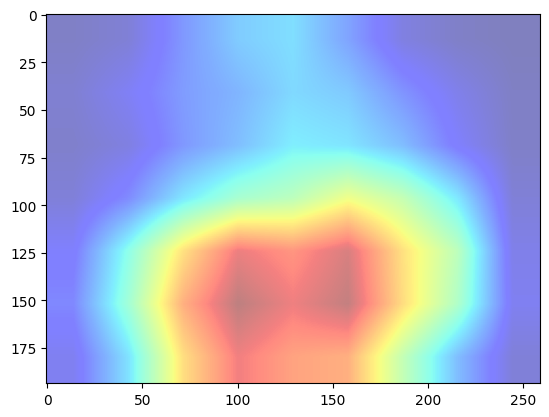

In [41]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [42]:
# reverse normalization for display
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

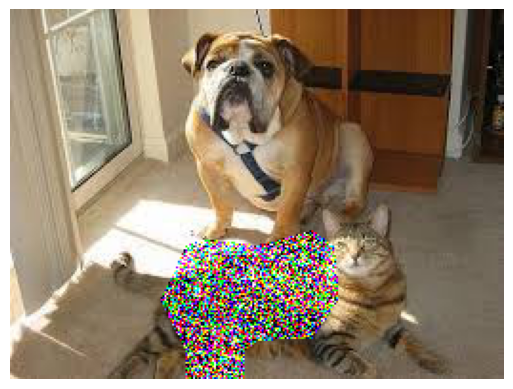

In [43]:
perturbed_tensor = perturb_image(tensor, cam, cam > 0.5, 0.1)
# Convert the tensor to a numpy array
image_array = perturbed_tensor.squeeze().permute(1,2,0).detach().cpu().numpy()

# Normalize the array to [0, 1]
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Show the image using matplotlib
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [44]:
perturbed_cam, perturbed_idx = wrapped_model(perturbed_tensor)
print(idx2label[perturbed_idx])

pug, pug-dog


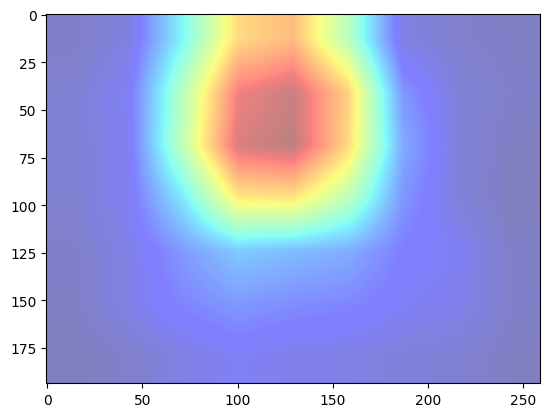

In [45]:
imshow(perturbed_cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [46]:
# reverse normalization for display
img = reverse_normalize(tensor)
heatmap = visualize(img, perturbed_cam)
save_image(heatmap, '/content/{}_scorecam.png'.format(idx2label[perturbed_idx]).replace(" ", "_").replace(",", ""))

#Sources:

1. Score-CAM:
Score-Weighted Visual Explanations for Convolutional Neural Networks: https://arxiv.org/abs/1910.01279

2. Demystifying Convolutional Neural Networks using ScoreCam: https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-scorecam-344a0456c48e

3. ScoreCAM Implementation

  a. https://github.com/keisen/tf-keras-vis

  b. https://github.com/yiskw713/ScoreCAM

  c. https://github.com/haofanwang/Score-CAM

4. Fooling Network Interpretation in Image Classification: https://arxiv.org/abs/1812.02843

  a. https://github.com/UMBCvision/fooling_network_interpretation
  

